##### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

##### Steps to follow:
1. Reading and understanding the data
2. Preparing data for modeling (split into train & test)
3. Training the model
4. Residual analysis
5. Prediction and evaluation on the test data

# 1. Reading and understanding the data

In [2]:
day_data = pd.read_csv("data.csv")
day_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
day_data.shape

(730, 16)

In [4]:
day_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
print("season: ",day_data['season'].unique())
print("weathersit", day_data['weathersit'].unique())

season:  [1 2 3 4]
weathersit [2 1 3]


In [6]:
day_data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [7]:
#convering to categorical variable.
day_data['weathersit'] = day_data['weathersit'].replace({1: 'Clear', 2: 'Mist', 3: 'Light_Snow', 4: 'Heavy_Rain'})
day_data['season'] = day_data['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
day_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,1,1,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,2,1,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,3,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,4,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,5,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


- Dropping the unnecessary columns

In [8]:
# Droping the instant column as it just a record index, and not useful for the model
day_data = day_data.drop(columns=['instant'])

# Dropping the casual and registered columns as cnt column is a addition of both
day_data = day_data.drop(columns=['casual', 'registered'])

# since dteday column is having the same data as month so we can drop the dteday column as well
day_data = day_data.drop(columns=['dteday'])

day_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,1,0,1,1,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,1,0,2,1,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,1,0,3,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,1,0,4,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,1,0,5,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


- Visualising the data

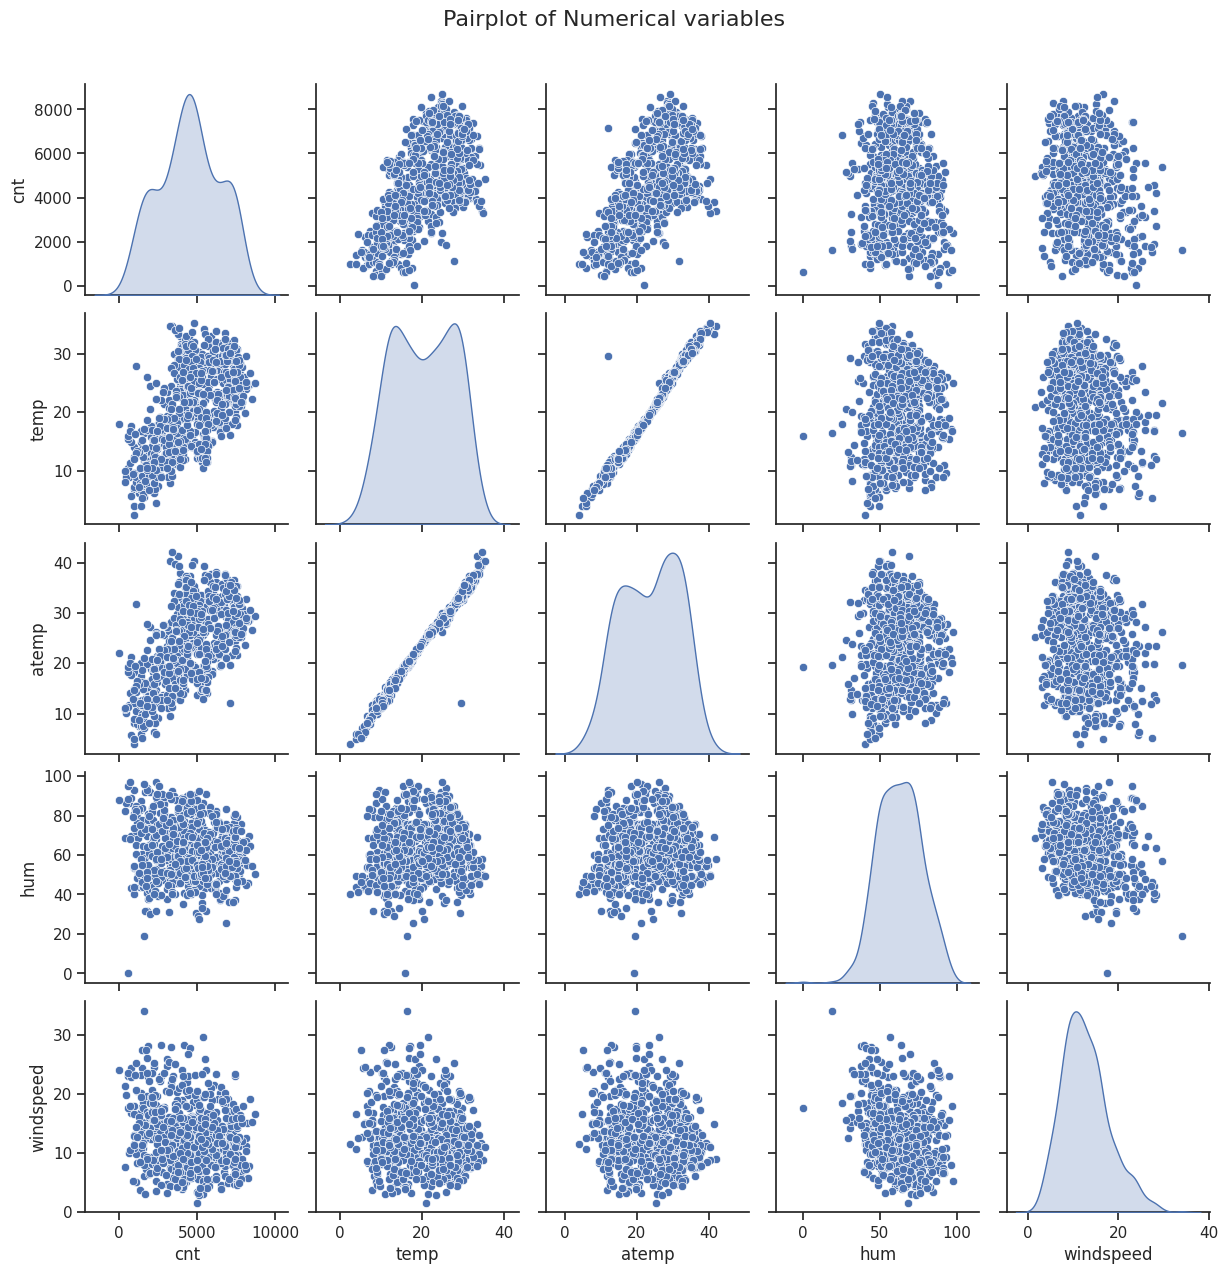

In [9]:
sns.set(style="ticks")

numerical_columns = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']

pairplot = sns.pairplot(day_data[numerical_columns], diag_kind='kde', markers='o', palette='deep')
pairplot.fig.suptitle('Pairplot of Numerical variables', y=1.02, fontsize=16)
pairplot.tight_layout()
plt.show()

In [10]:
#From the above graph, it is clear that the 'atemp' and 'temp' columns are highly correlated;
correlation = day_data['temp'].corr(day_data['atemp'])
print("Correlation of temp and atemp columns: ", correlation)

Correlation of temp and atemp columns:  0.991696178690565


In [11]:
#The correlation of temp and atemp columns is almost 1 hence we can remove any of them, here we will remove the atemp column.
day_data = day_data.drop(columns=['atemp'])
day_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,0,1,0,1,1,Mist,14.110847,80.5833,10.749882,985
1,spring,0,1,0,2,1,Mist,14.902598,69.6087,16.652113,801
2,spring,0,1,0,3,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,1,0,4,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,1,0,5,1,Clear,9.305237,43.6957,12.522300,1600


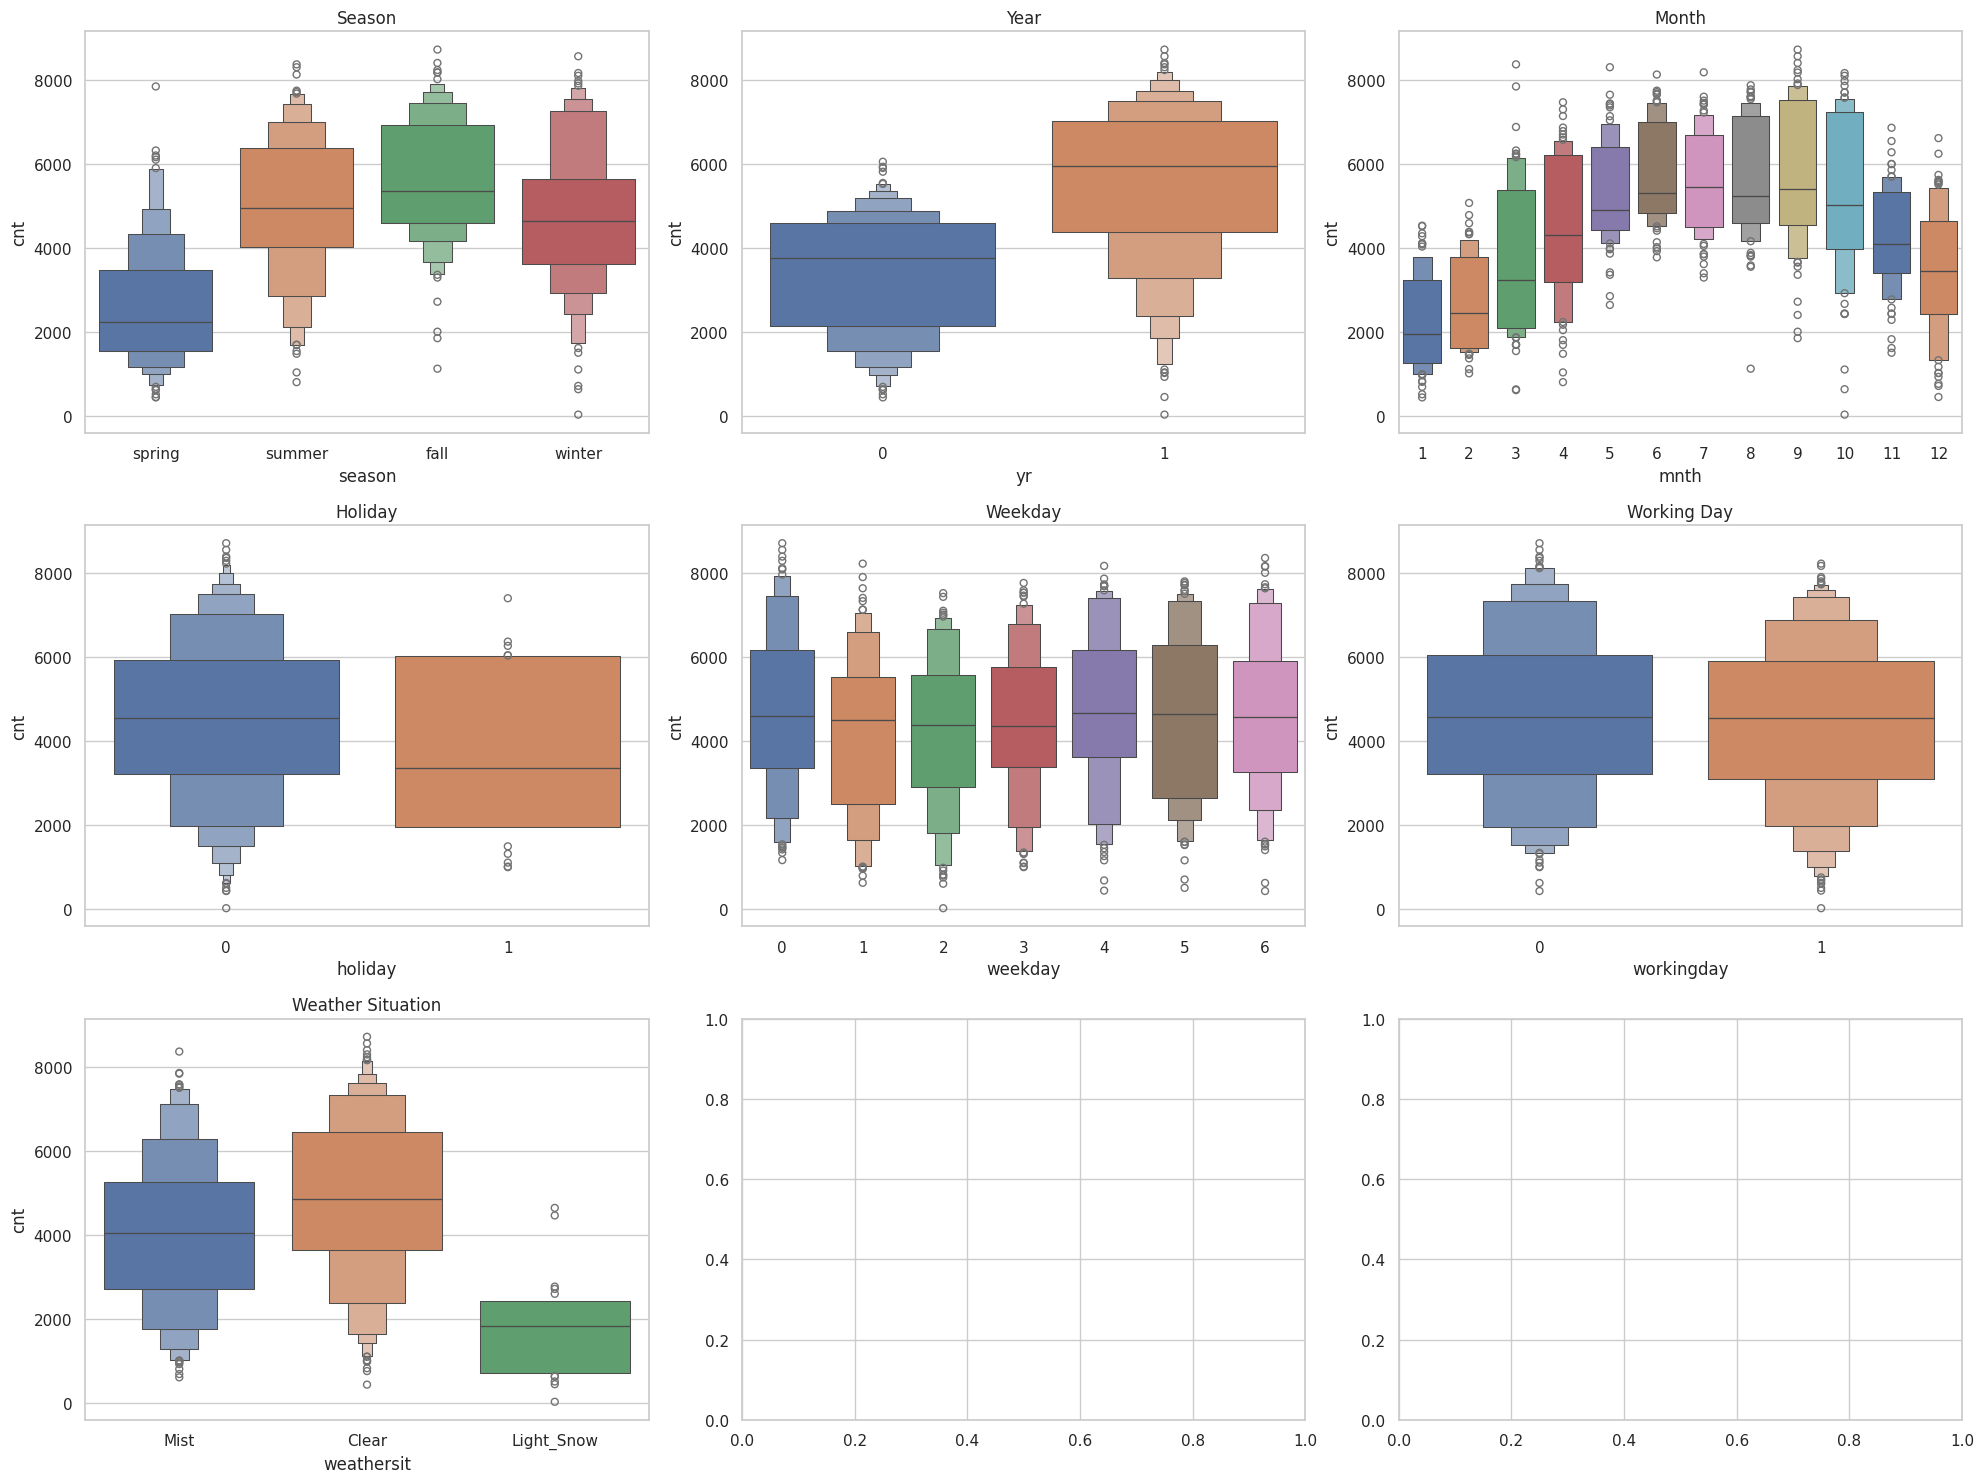

In [12]:
# Set Seaborn style
sns.set(style="whitegrid")

# Visualizing the categorical columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))

sns.boxenplot(x='season', y='cnt', data=day_data, ax=axes[0, 0], palette="deep")
axes[0, 0].set_title('Season')

sns.boxenplot(x='yr', y='cnt', data=day_data, ax=axes[0, 1], palette="deep")
axes[0, 1].set_title('Year')

sns.boxenplot(x='mnth', y='cnt', data=day_data, ax=axes[0, 2], palette="deep")
axes[0, 2].set_title('Month')

sns.boxenplot(x='holiday', y='cnt', data=day_data, ax=axes[1, 0], palette="deep")
axes[1, 0].set_title('Holiday')

sns.boxenplot(x='weekday', y='cnt', data=day_data, ax=axes[1, 1], palette="deep")
axes[1, 1].set_title('Weekday')

sns.boxenplot(x='workingday', y='cnt', data=day_data, ax=axes[1, 2], palette="deep")
axes[1, 2].set_title('Working Day')

sns.boxenplot(x='weathersit', y='cnt', data=day_data, ax=axes[2, 0], palette="deep")
axes[2, 0].set_title('Weather Situation')

# # Adjust layout
fig.tight_layout()

# Display the plots
plt.show()

# 2. Preparing the data for the modeling

In [13]:
#Creating dummy variables
season_column = pd.get_dummies(day_data['season'], drop_first=True)
month_column = pd.get_dummies(day_data['mnth'], drop_first=True)
weekday_column = pd.get_dummies(day_data['weekday'], drop_first=True)
weathersit_column = pd.get_dummies(day_data['weathersit'], drop_first=True)

In [14]:
#Concating the dummy variables with the original data and renaming the columns for better interpretation
day_data = pd.concat([day_data, season_column, weathersit_column], axis=1)

day_data = pd.concat([day_data, month_column], axis=1)
day_data.rename(columns={2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                           7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}, inplace=True)

day_data = pd.concat([day_data, weekday_column], axis=1)
day_data.rename(columns={1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}, inplace=True)

day_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
0,spring,0,1,0,1,1,Mist,14.110847,80.5833,10.749882,...,0,0,0,0,1,0,0,0,0,0
1,spring,0,1,0,2,1,Mist,14.902598,69.6087,16.652113,...,0,0,0,0,0,1,0,0,0,0
2,spring,0,1,0,3,1,Clear,8.050924,43.7273,16.636703,...,0,0,0,0,0,0,1,0,0,0
3,spring,0,1,0,4,1,Clear,8.200000,59.0435,10.739832,...,0,0,0,0,0,0,0,1,0,0
4,spring,0,1,0,5,1,Clear,9.305237,43.6957,12.522300,...,0,0,0,0,0,0,0,0,1,0


In [15]:
#After concatinating the dummy variables we can remove the original categorical columns
day_data = day_data.drop(columns=['season', 'mnth', 'weekday', 'weathersit'], axis=1)
day_data.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
day_data.shape

(730, 29)

- Splitting data into train and test

In [17]:
# Rearranging the columns for better understanding before splitting the data into train and test
day_data = day_data.reindex(columns=['cnt', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer', 'winter', 'Light_Snow', 
                                     'Mist', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
day_data.head()

,cnt,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
0,985,0,0,1,14.110847,80.5833,10.749882,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,801,0,0,1,14.902598,69.6087,16.652113,1,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1349,0,0,1,8.050924,43.7273,16.636703,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1562,0,0,1,8.200000,59.0435,10.739832,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1600,0,0,1,9.305237,43.6957,12.522300,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [18]:
train_data, test_data = train_test_split(day_data, train_size=0.7, random_state=100)
print(train_data.shape)
print(test_data.shape)

(510, 29)
(220, 29)


- Rescalling the features

In [19]:
# Initiate the object
scaler = MinMaxScaler()

#Fit on data
train_data[['temp', 'hum', 'windspeed', 'cnt']] = scaler.fit_transform(train_data[['temp', 'hum', 'windspeed', 'cnt']])
train_data.head()

,cnt,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
576,0.827658,1,0,1,0.815169,0.725633,0.264686,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,0.465255,1,0,0,0.442393,0.640189,0.255342,1,0,0,...,0,0,0,0,0,0,0,0,0,0
728,0.204096,1,0,1,0.245101,0.498067,0.663106,1,0,0,...,0,0,0,1,1,0,0,0,0,0
482,0.482973,1,0,0,0.395666,0.504508,0.188475,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111,0.191095,0,0,0,0.345824,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# 3. Traininig the model

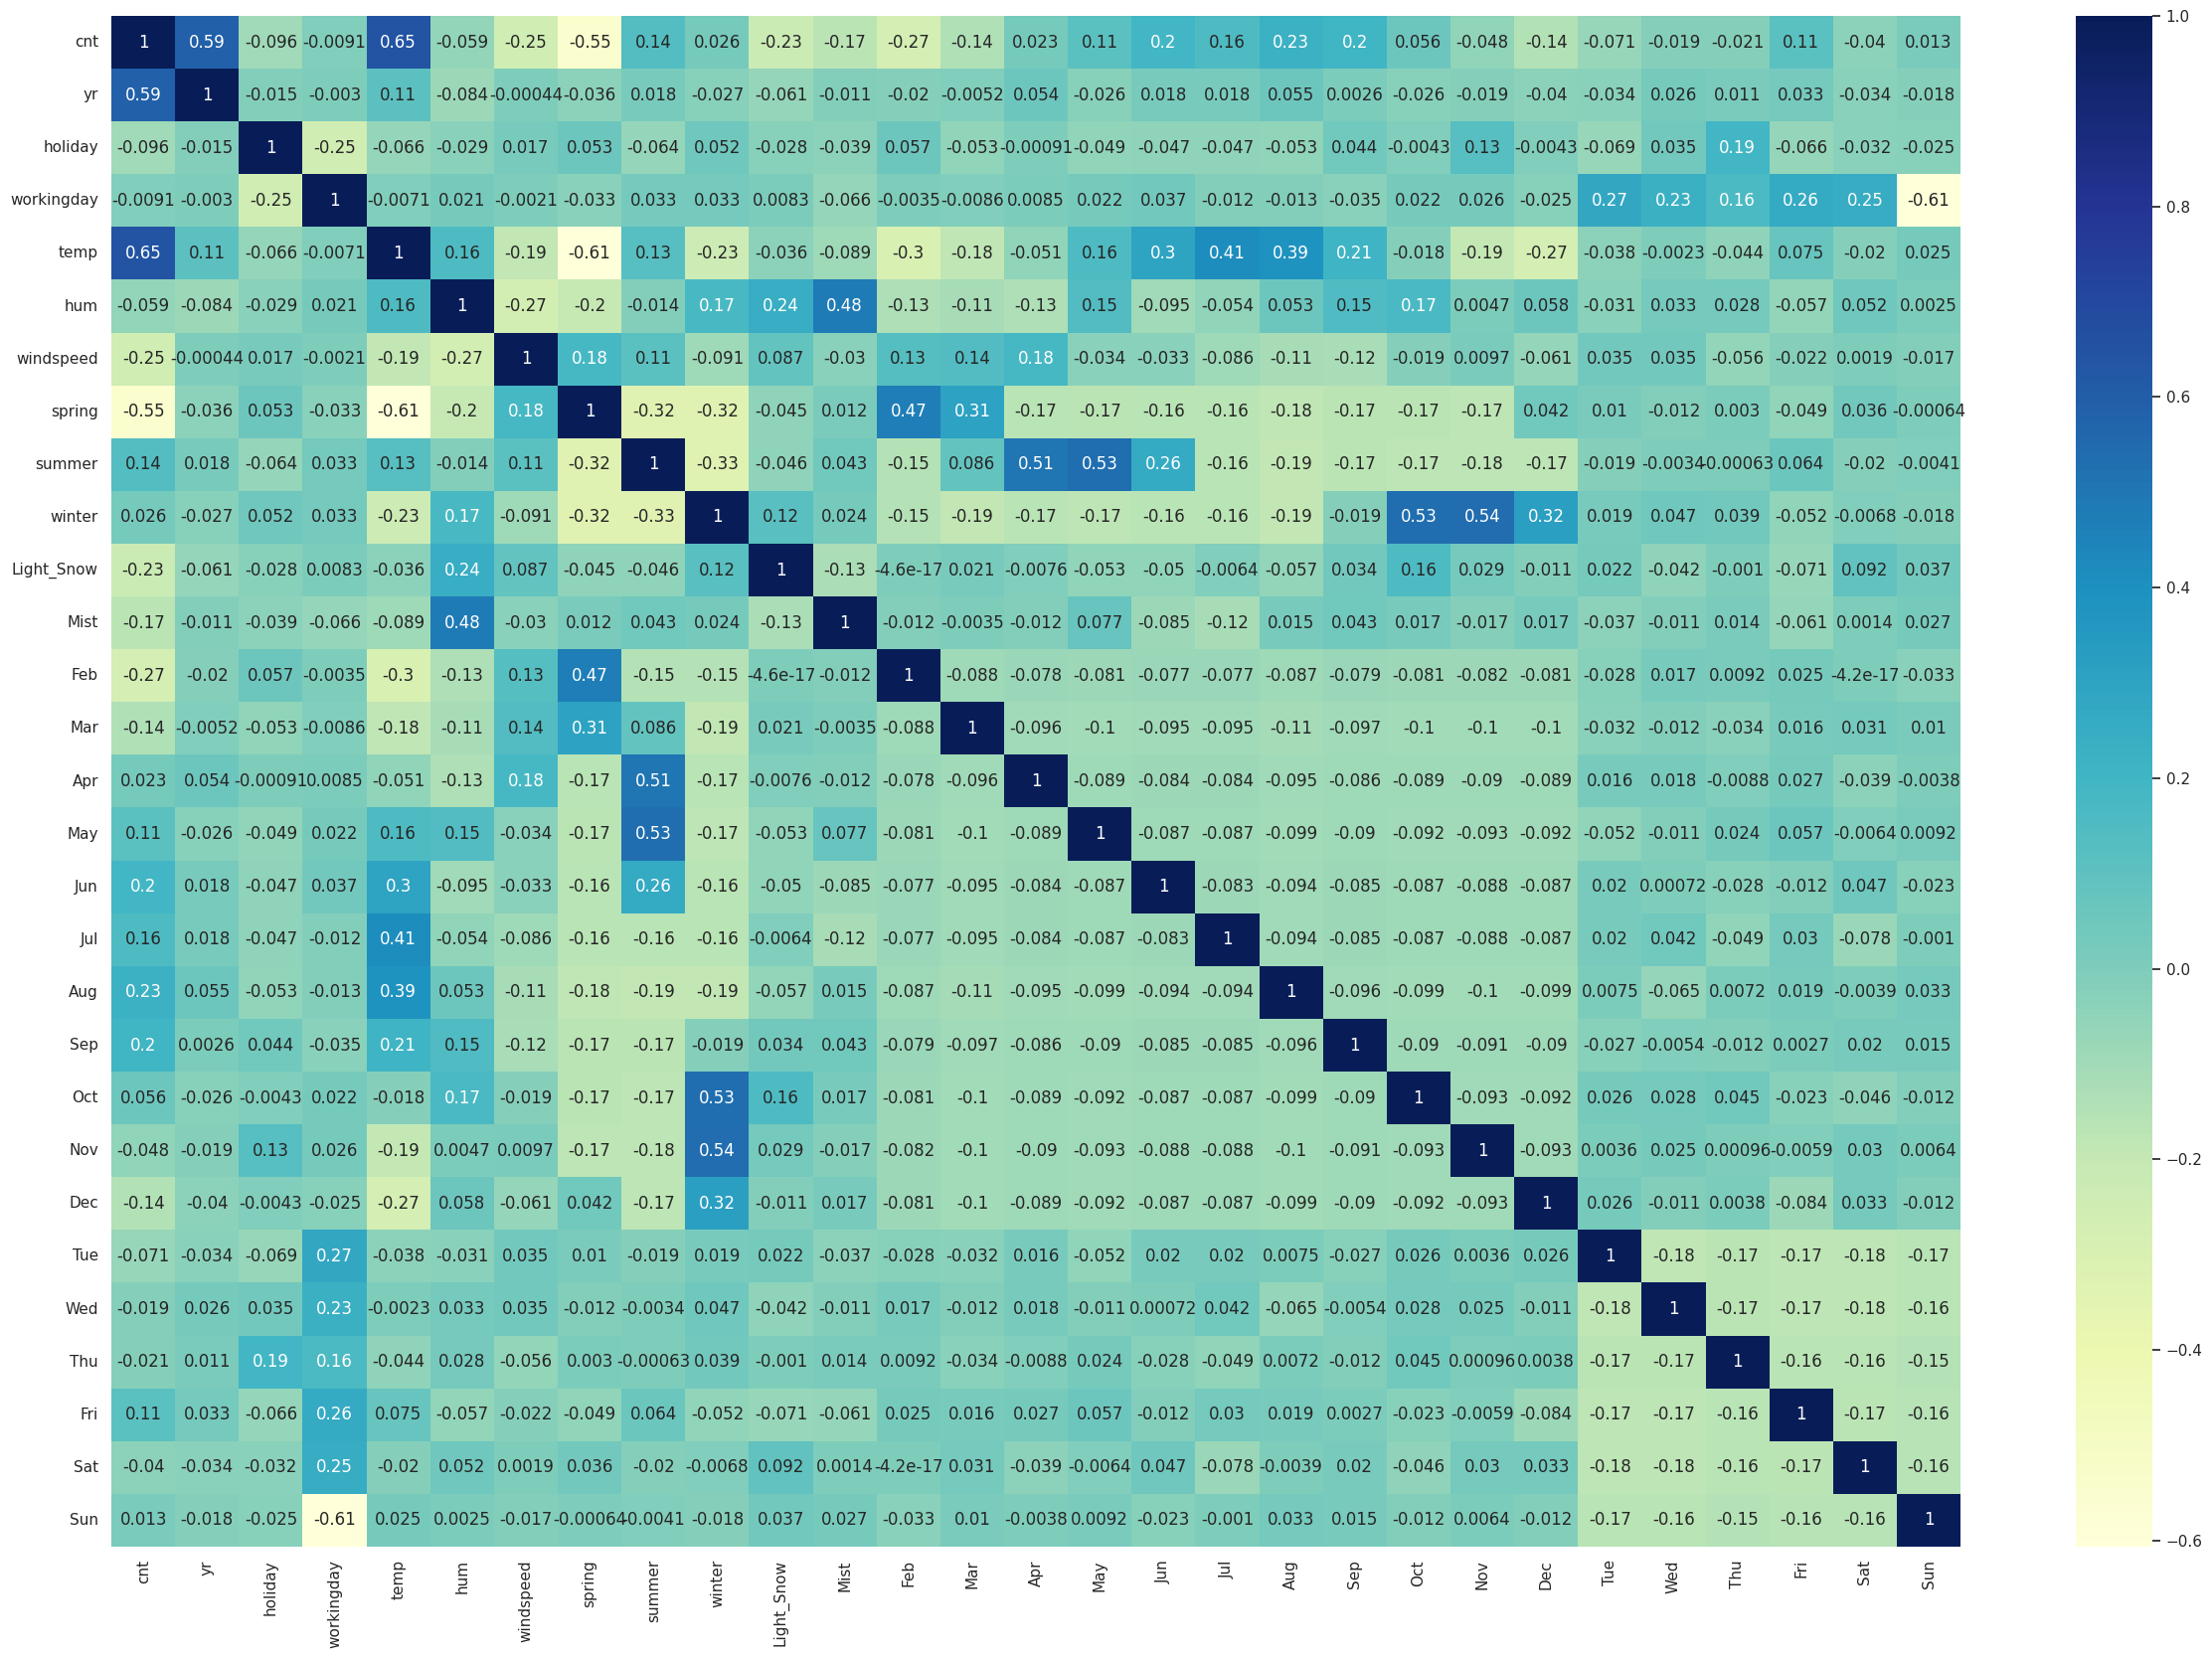

In [20]:
#Creating a heatmap to check the correlation of the variables with count variable
plt.figure(figsize = (30, 20))
sns.heatmap(train_data.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [21]:
train_data.head()

,cnt,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
576,0.827658,1,0,1,0.815169,0.725633,0.264686,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,0.465255,1,0,0,0.442393,0.640189,0.255342,1,0,0,...,0,0,0,0,0,0,0,0,0,0
728,0.204096,1,0,1,0.245101,0.498067,0.663106,1,0,0,...,0,0,0,1,1,0,0,0,0,0
482,0.482973,1,0,0,0.395666,0.504508,0.188475,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111,0.191095,0,0,0,0.345824,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,0


- Creating X_train and y_train

In [22]:
y_train = train_data.pop('cnt')
X_train = train_data

In [23]:
y_train.head()

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64

In [24]:
X_train.shape

(510, 28)

- Building the model using statsmodel
- We will build the model with all the variables and remove one variable at a time based on the significance.

In [25]:
# Checking the columns
day_data.columns

Index(['cnt', 'yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'spring', 'summer', 'winter', 'Light_Snow', 'Mist', 'Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Sun'],
      dtype='object')

#### Bulding the model with all the variables

- We will go with the RFE approach to select the best 15 features for the model

In [26]:
lm_rfe = LinearRegression()

# fit the model
lm_rfe.fit(X_train, y_train)

# running the RFE to select the 15 features
lm_model_rfe = RFE(estimator=lm_rfe, n_features_to_select=15)
lm_model_rfe = lm_model_rfe.fit(X_train, y_train)

In [27]:
list(zip(X_train.columns,lm_model_rfe.support_,lm_model_rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 4),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('Light_Snow', True, 1),
 ('Mist', True, 1),
 ('Feb', False, 10),
 ('Mar', True, 1),
 ('Apr', False, 3),
 ('May', True, 1),
 ('Jun', False, 2),
 ('Jul', False, 11),
 ('Aug', True, 1),
 ('Sep', True, 1),
 ('Oct', True, 1),
 ('Nov', False, 12),
 ('Dec', False, 13),
 ('Tue', False, 8),
 ('Wed', False, 9),
 ('Thu', False, 7),
 ('Fri', False, 5),
 ('Sat', False, 6),
 ('Sun', False, 14)]

In [28]:
# Printing the RFE supported columns
rfe_supported_cols = X_train.columns[lm_model_rfe.support_]
rfe_supported_cols

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'Light_Snow', 'Mist', 'Mar', 'May', 'Aug', 'Sep', 'Oct'],
      dtype='object')

In [29]:
# Printing the RFE rejected columns
X_train.columns[~lm_model_rfe.support_]

Index(['workingday', 'Feb', 'Apr', 'Jun', 'Jul', 'Nov', 'Dec', 'Tue', 'Wed',
       'Thu', 'Fri', 'Sat', 'Sun'],
      dtype='object')

In [30]:
# Creating X_train dataframe with RFE selected variables
X_train = X_train[rfe_supported_cols]
X_train.head()

,yr,holiday,temp,hum,windspeed,spring,summer,winter,Light_Snow,Mist,Mar,May,Aug,Sep,Oct
576,1,0,0.815169,0.725633,0.264686,0,0,0,0,0,0,0,0,0,0
426,1,0,0.442393,0.640189,0.255342,1,0,0,0,1,1,0,0,0,0
728,1,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.504508,0.188475,0,1,0,0,1,0,0,0,0,0
111,0,0,0.345824,0.751824,0.380981,0,1,0,0,1,0,0,0,0,0


In [31]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     179.3
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          1.00e-188
Time:                        17:51:01   Log-Likelihood:                 513.97
No. Observations:                 510   AIC:                            -995.9
Df Residuals:                     494   BIC:                            -928.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2799      0.036      7.775      0.000       0.209       0.351
yr             0.2304      0.008     28.453      0.000       0.215       0.246
holiday       -0.0889      0.025     -3.487      0.001      -0.139      -0.039
temp           0.4869      0.034     14.119      0.000       0.419       0.555
hum           -0.1796      0.038     -4.734      0.000      -0.254      -0.105
windspeed     -0.1839      0.026     -7.162      0.000      -0.234      -0.133
spring        -0.0425      0.023     -1.847      0.065      -0.088       0.003
summer         0.0741      0.018      4.098      0.000       0.039       0.110
winter         0.1105      0.020      5.482      0.000       0.071       0.150
Light_Snow    -0.2429      0.026     -9.185      0.000      -0.295      -0.191
Mist          -0.0542      0.010     -5.187      0.000      -0.075      -0.034
Mar            0.0323      0.015      2.196      0.029       0.003       0.061
May            0.0282      0.018      1.581      0.115      -0.007       0.063
Aug            0.0509      0.017      2.913      0.004       0.017       0.085
Sep            0.1207      0.017      6.984      0.000       0.087       0.155
Oct            0.0407      0.018      2.314      0.021       0.006       0.075
==============================================================================
Omnibus:                       73.210   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.011
Skew:                          -0.739   Prob(JB):                     8.15e-40
Kurtosis:                       5.507   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Creating a function to check VIF

In [32]:
# Function to check VIF
def check_vif(df):
    vif = pd.DataFrame()
    X = df
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

- We will remove the column having VIF >5

In [33]:
check_vif(X_train)

,Features,VIF
3,hum,29.46
2,temp,15.38
4,windspeed,4.77
5,spring,4.72
7,winter,4.30
6,summer,3.85
9,Mist,2.29
0,yr,2.10
12,Aug,1.80
11,May,1.63


- Since the VIF of the hum is >5, we will remove it

In [34]:
# Removing the variables having high VIF
X_train = X_train.drop(columns=['hum'], axis=1)
X_train.head()

,yr,holiday,temp,windspeed,spring,summer,winter,Light_Snow,Mist,Mar,May,Aug,Sep,Oct
576,1,0,0.815169,0.264686,0,0,0,0,0,0,0,0,0,0
426,1,0,0.442393,0.255342,1,0,0,0,1,1,0,0,0,0
728,1,0,0.245101,0.663106,1,0,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.188475,0,1,0,0,1,0,0,0,0,0
111,0,0,0.345824,0.380981,0,1,0,0,1,0,0,0,0,0


In [35]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     182.6
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          3.97e-185
Time:                        17:51:02   Log-Likelihood:                 502.66
No. Observations:                 510   AIC:                            -975.3
Df Residuals:                     495   BIC:                            -911.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1909      0.031      6.088      0.000       0.129       0.253
yr             0.2345      0.008     28.504      0.000       0.218       0.251
holiday       -0.0899      0.026     -3.452      0.001      -0.141      -0.039
temp           0.4530      0.034     13.147      0.000       0.385       0.521
windspeed     -0.1498      0.025     -5.952      0.000      -0.199      -0.100
spring        -0.0554      0.023     -2.373      0.018      -0.101      -0.010
summer         0.0676      0.018      3.668      0.000       0.031       0.104
winter         0.0931      0.020      4.599      0.000       0.053       0.133
Light_Snow    -0.2919      0.025    -11.746      0.000      -0.341      -0.243
Mist          -0.0822      0.009     -9.352      0.000      -0.099      -0.065
Mar            0.0339      0.015      2.259      0.024       0.004       0.063
May            0.0173      0.018      0.960      0.338      -0.018       0.053
Aug            0.0450      0.018      2.528      0.012       0.010       0.080
Sep            0.1101      0.018      6.293      0.000       0.076       0.145
Oct            0.0373      0.018      2.076      0.038       0.002       0.073
==============================================================================
Omnibus:                       72.480   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.779
Skew:                          -0.737   Prob(JB):                     6.76e-39
Kurtosis:                       5.470   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
check_vif(X_train)

,Features,VIF
2,temp,5.23
3,windspeed,4.71
5,summer,3.06
4,spring,2.38
6,winter,2.29
0,yr,2.08
11,Aug,1.73
10,May,1.63
13,Oct,1.59
8,Mist,1.58


- Since the p value of the 'May' variable is high and VIF is is low, we will remove it

In [37]:
# Removing the variables having high VIF
X_train = X_train.drop(columns=['May'], axis=1)
X_train.head()

,yr,holiday,temp,windspeed,spring,summer,winter,Light_Snow,Mist,Mar,Aug,Sep,Oct
576,1,0,0.815169,0.264686,0,0,0,0,0,0,0,0,0
426,1,0,0.442393,0.255342,1,0,0,0,1,1,0,0,0
728,1,0,0.245101,0.663106,1,0,0,0,0,0,0,0,0
482,1,0,0.395666,0.188475,0,1,0,0,1,0,0,0,0
111,0,0,0.345824,0.380981,0,1,0,0,1,0,0,0,0


In [38]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     196.6
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          4.39e-186
Time:                        17:51:02   Log-Likelihood:                 502.18
No. Observations:                 510   AIC:                            -976.4
Df Residuals:                     496   BIC:                            -917.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1861      0.031      6.012      0.000       0.125       0.247
yr             0.2340      0.008     28.506      0.000       0.218       0.250
holiday       -0.0906      0.026     -3.480      0.001      -0.142      -0.039
temp           0.4599      0.034     13.651      0.000       0.394       0.526
windspeed     -0.1519      0.025     -6.060      0.000      -0.201      -0.103
spring        -0.0510      0.023     -2.230      0.026      -0.096      -0.006
summer         0.0754      0.016      4.571      0.000       0.043       0.108
winter         0.0958      0.020      4.778      0.000       0.056       0.135
Light_Snow    -0.2919      0.025    -11.746      0.000      -0.341      -0.243
Mist          -0.0816      0.009     -9.307      0.000      -0.099      -0.064
Mar            0.0312      0.015      2.115      0.035       0.002       0.060
Aug            0.0449      0.018      2.522      0.012       0.010       0.080
Sep            0.1101      0.018      6.292      0.000       0.076       0.144
Oct            0.0365      0.018      2.033      0.043       0.001       0.072
==============================================================================
Omnibus:                       70.952   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.536
Skew:                          -0.733   Prob(JB):                     6.87e-37
Kurtosis:                       5.385   Cond. No.                         18.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
check_vif(X_train)

,Features,VIF
2,temp,5.12
3,windspeed,4.62
5,summer,2.44
4,spring,2.35
6,winter,2.29
0,yr,2.07
10,Aug,1.73
12,Oct,1.59
8,Mist,1.58
11,Sep,1.41


- Here the VIF of the 'temp' variable is high but we have seen earlier in the pair plot that 'temp' variable is corelated with the target variable.
- So it is an important variable for model building, hence we will remove the 'Oct' variable and check if the VIF of the variable is descresing or not.

In [40]:
# Removing the variables having high VIF
X_train = X_train.drop(columns=['Oct'], axis=1)
X_train.head()

,yr,holiday,temp,windspeed,spring,summer,winter,Light_Snow,Mist,Mar,Aug,Sep
576,1,0,0.815169,0.264686,0,0,0,0,0,0,0,0
426,1,0,0.442393,0.255342,1,0,0,0,1,1,0,0
728,1,0,0.245101,0.663106,1,0,0,0,0,0,0,0
482,1,0,0.395666,0.188475,0,1,0,0,1,0,0,0
111,0,0,0.345824,0.380981,0,1,0,0,1,0,0,0


In [41]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.3
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          2.29e-186
Time:                        17:51:02   Log-Likelihood:                 500.07
No. Observations:                 510   AIC:                            -974.1
Df Residuals:                     497   BIC:                            -919.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1742      0.030      5.713      0.000       0.114       0.234
yr             0.2334      0.008     28.365      0.000       0.217       0.250
holiday       -0.0920      0.026     -3.525      0.000      -0.143      -0.041
temp           0.4758      0.033     14.469      0.000       0.411       0.540
windspeed     -0.1500      0.025     -5.970      0.000      -0.199      -0.101
spring        -0.0445      0.023     -1.956      0.051      -0.089       0.000
summer         0.0773      0.017      4.679      0.000       0.045       0.110
winter         0.1124      0.018      6.122      0.000       0.076       0.148
Light_Snow    -0.2856      0.025    -11.546      0.000      -0.334      -0.237
Mist          -0.0807      0.009     -9.187      0.000      -0.098      -0.063
Mar            0.0306      0.015      2.071      0.039       0.002       0.060
Aug            0.0436      0.018      2.441      0.015       0.009       0.079
Sep            0.1066      0.017      6.101      0.000       0.072       0.141
==============================================================================
Omnibus:                       61.266   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.203
Skew:                          -0.664   Prob(JB):                     1.19e-29
Kurtosis:                       5.123   Cond. No.                         18.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
check_vif(X_train)

,Features,VIF
2,temp,5.02
3,windspeed,4.62
5,summer,2.43
4,spring,2.35
0,yr,2.07
6,winter,1.87
10,Aug,1.72
8,Mist,1.58
11,Sep,1.37
9,Mar,1.29


- The p value of the 'spring' is high compared to other variables, so we will remove it and check if the VIF is descresing or not

In [43]:
# Removing the variables having high VIF
X_train = X_train.drop(columns=['spring'], axis=1)
X_train.head()

,yr,holiday,temp,windspeed,summer,winter,Light_Snow,Mist,Mar,Aug,Sep
576,1,0,0.815169,0.264686,0,0,0,0,0,0,0
426,1,0,0.442393,0.255342,0,0,0,1,1,0,0
728,1,0,0.245101,0.663106,0,0,0,0,0,0,0
482,1,0,0.395666,0.188475,1,0,0,1,0,0,0
111,0,0,0.345824,0.380981,1,0,0,1,0,0,0


In [44]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.8
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          9.87e-187
Time:                        17:51:02   Log-Likelihood:                 498.11
No. Observations:                 510   AIC:                            -972.2
Df Residuals:                     498   BIC:                            -921.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1246      0.017      7.322      0.000       0.091       0.158
yr             0.2324      0.008     28.218      0.000       0.216       0.249
holiday       -0.0940      0.026     -3.593      0.000      -0.145      -0.043
temp           0.5233      0.022     23.568      0.000       0.480       0.567
windspeed     -0.1526      0.025     -6.065      0.000      -0.202      -0.103
summer         0.1013      0.011      9.145      0.000       0.080       0.123
winter         0.1413      0.011     12.925      0.000       0.120       0.163
Light_Snow    -0.2833      0.025    -11.434      0.000      -0.332      -0.235
Mist          -0.0811      0.009     -9.208      0.000      -0.098      -0.064
Mar            0.0249      0.015      1.716      0.087      -0.004       0.053
Aug            0.0563      0.017      3.374      0.001       0.024       0.089
Sep            0.1180      0.017      7.152      0.000       0.086       0.150
==============================================================================
Omnibus:                       54.964   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.001
Skew:                          -0.619   Prob(JB):                     2.90e-25
Kurtosis:                       4.945   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
check_vif(X_train)

,Features,VIF
2,temp,5.01
3,windspeed,3.29
0,yr,2.01
4,summer,1.82
9,Aug,1.59
5,winter,1.52
7,Mist,1.49
10,Sep,1.31
8,Mar,1.19
6,Light_Snow,1.08


- The p value of the 'Mar' is high compared to other variables, so we will remove it and check if the VIF is descresing or not

In [46]:
# Removing the variables having high VIF
X_train = X_train.drop(columns=['Mar'], axis=1)
X_train.head()

,yr,holiday,temp,windspeed,summer,winter,Light_Snow,Mist,Aug,Sep
576,1,0,0.815169,0.264686,0,0,0,0,0,0
426,1,0,0.442393,0.255342,0,0,0,1,0,0
728,1,0,0.245101,0.663106,0,0,0,0,0,0
482,1,0,0.395666,0.188475,1,0,0,1,0,0
111,0,0,0.345824,0.380981,1,0,0,1,0,0


In [47]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     250.5
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          2.62e-187
Time:                        17:51:02   Log-Likelihood:                 496.61
No. Observations:                 510   AIC:                            -971.2
Df Residuals:                     499   BIC:                            -924.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1307      0.017      7.837      0.000       0.098       0.163
yr             0.2326      0.008     28.191      0.000       0.216       0.249
holiday       -0.0966      0.026     -3.692      0.000      -0.148      -0.045
temp           0.5173      0.022     23.546      0.000       0.474       0.561
windspeed     -0.1497      0.025     -5.950      0.000      -0.199      -0.100
summer         0.1012      0.011      9.116      0.000       0.079       0.123
winter         0.1371      0.011     12.843      0.000       0.116       0.158
Light_Snow    -0.2819      0.025    -11.361      0.000      -0.331      -0.233
Mist          -0.0811      0.009     -9.200      0.000      -0.098      -0.064
Aug            0.0541      0.017      3.249      0.001       0.021       0.087
Sep            0.1163      0.017      7.046      0.000       0.084       0.149
==============================================================================
Omnibus:                       55.243   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              119.255
Skew:                          -0.606   Prob(JB):                     1.27e-26
Kurtosis:                       5.036   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
check_vif(X_train)

,Features,VIF
2,temp,5.01
3,windspeed,3.10
0,yr,2.00
4,summer,1.82
8,Aug,1.58
7,Mist,1.49
5,winter,1.48
9,Sep,1.31
6,Light_Snow,1.08
1,holiday,1.04


- The p value of the 'Aug' is high compared to other variables, so we will remove it and check if the VIF is descresing or not

In [49]:
# Removing the variables having high VIF
X_train = X_train.drop(columns=['Aug'], axis=1)
X_train.head()

,yr,holiday,temp,windspeed,summer,winter,Light_Snow,Mist,Sep
576,1,0,0.815169,0.264686,0,0,0,0,0
426,1,0,0.442393,0.255342,0,0,0,1,0
728,1,0,0.245101,0.663106,0,0,0,0,0
482,1,0,0.395666,0.188475,1,0,0,1,0
111,0,0,0.345824,0.380981,1,0,0,1,0


In [50]:
# Adding the constant
X_train_model = sm.add_constant(X_train)

# Creating the model
lr_sm = sm.OLS(y_train, X_train_model)

# fit the model
lr_sm_model = lr_sm.fit()

#parameters of the model
lr_sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     271.9
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          2.83e-186
Time:                        17:51:02   Log-Likelihood:                 491.27
No. Observations:                 510   AIC:                            -962.5
Df Residuals:                     500   BIC:                            -920.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1259      0.017      7.508      0.000       0.093       0.159
yr             0.2329      0.008     27.962      0.000       0.216       0.249
holiday       -0.0987      0.026     -3.738      0.000      -0.151      -0.047
temp           0.5480      0.020     27.360      0.000       0.509       0.587
windspeed     -0.1532      0.025     -6.039      0.000      -0.203      -0.103
summer         0.0881      0.010      8.437      0.000       0.068       0.109
winter         0.1293      0.011     12.314      0.000       0.109       0.150
Light_Snow    -0.2829      0.025    -11.295      0.000      -0.332      -0.234
Mist          -0.0784      0.009     -8.844      0.000      -0.096      -0.061
Sep            0.1012      0.016      6.330      0.000       0.070       0.133
==============================================================================
Omnibus:                       57.077   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.844
Skew:                          -0.648   Prob(JB):                     1.15e-25
Kurtosis:                       4.930   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
check_vif(X_train)

,Features,VIF
2,temp,3.68
3,windspeed,3.06
0,yr,2.00
4,summer,1.57
7,Mist,1.48
5,winter,1.37
8,Sep,1.20
6,Light_Snow,1.08
1,holiday,1.04


- As we can see that after removing the 'Aug' variable, The VIF of the other variables is descreased significantly.
- The model appears to be good and it is showing minimal multicollinearity among predictors and statistically significant p-values for all features.
- For now we will consider it as a our final model

# 4. Residual analysis

In [52]:
y_train_pred = lr_sm_model.predict(X_train_model)
y_train_pred

576    0.764943
426    0.483717
728    0.391485
482    0.556437
111    0.266762
         ...   
578    0.803572
53     0.219894
350    0.246747
79     0.307973
520    0.642313
Length: 510, dtype: float64

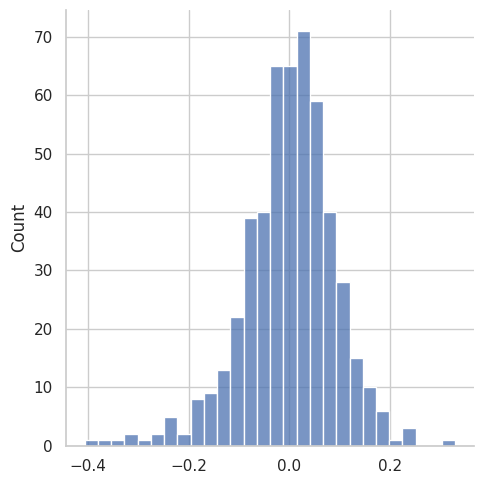

In [53]:
residuals = y_train - y_train_pred
sns.displot(residuals)

# 5. Prediction and evaluation on the test data

In [54]:
#Fit on data
test_data[['temp', 'hum', 'windspeed', 'cnt']] = scaler.transform(test_data[['temp', 'hum', 'windspeed', 'cnt']])
test_data.head()

,cnt,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
184,0.692706,0,1,0,0.831783,0.657364,0.084219,0,0,0,...,0,0,0,0,0,0,1,0,0,0
535,0.712034,1,0,1,0.901354,0.610133,0.153728,0,1,0,...,0,0,0,0,0,0,0,1,0,0
299,0.303382,0,0,0,0.511964,0.837699,0.334206,0,0,1,...,0,1,0,0,0,0,0,0,0,1
221,0.547400,0,0,1,0.881625,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,0,1,0
152,0.569029,0,0,0,0.817246,0.314298,0.537414,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [55]:
test_data.describe()

,cnt,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.522154,0.481818,0.036364,0.640909,0.558718,0.638221,0.313293,0.254545,0.263636,0.236364,...,0.086364,0.086364,0.072727,0.086364,0.118182,0.122727,0.159091,0.140909,0.131818,0.172727
std,0.219163,0.500809,0.187620,0.480828,0.233187,0.148694,0.159584,0.436599,0.441609,0.425817,...,0.281541,0.281541,0.260281,0.281541,0.323559,0.328872,0.366595,0.348721,0.339064,0.378873
min,0.048205,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378595,0.000000,0.000000,0.000000,0.355429,0.529197,0.198843,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.524678,0.000000,0.000000,1.000000,0.558172,0.625590,0.300126,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.677750,1.000000,0.000000,1.000000,0.755981,0.743798,0.402718,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.963300,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
y_test = test_data.pop('cnt')
X_test = test_data

- Adding a constant to make predictions

In [57]:
X_test_sm_model = sm.add_constant(X_test)
X_test_sm_model.head()

,const,yr,holiday,workingday,temp,hum,windspeed,spring,summer,winter,...,Sep,Oct,Nov,Dec,Tue,Wed,Thu,Fri,Sat,Sun
184,1.0,0,1,0,0.831783,0.657364,0.084219,0,0,0,...,0,0,0,0,0,0,1,0,0,0
535,1.0,1,0,1,0.901354,0.610133,0.153728,0,1,0,...,0,0,0,0,0,0,0,1,0,0
299,1.0,0,0,0,0.511964,0.837699,0.334206,0,0,1,...,0,1,0,0,0,0,0,0,0,1
221,1.0,0,0,1,0.881625,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,0,1,0
152,1.0,0,0,0,0.817246,0.314298,0.537414,0,1,0,...,0,0,0,0,0,0,0,0,0,1


- As we removed some of the variables from training data set during the model building, hence we will remove those variables from test data.

In [58]:
X_test_sm_model = X_test_sm_model.drop(columns=['hum', 'May', 'Oct', 'spring', 'Mar', 'Aug', 'workingday', 'Feb', 'Apr', 'Jun', 'Jul', 
                                                 'Nov', 'Dec', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], axis=1)
X_test_sm_model.head()

,const,yr,holiday,temp,windspeed,summer,winter,Light_Snow,Mist,Sep
184,1.0,0,1,0.831783,0.084219,0,0,0,1,0
535,1.0,1,0,0.901354,0.153728,1,0,0,0,0
299,1.0,0,0,0.511964,0.334206,0,1,0,1,0
221,1.0,0,0,0.881625,0.339570,0,0,0,0,0
152,1.0,0,0,0.817246,0.537414,1,0,0,0,0


- Making the prediction

In [59]:
y_test_pred = lr_sm_model.predict(X_test_sm_model)

- Evaluating the model

In [60]:
print("R-squared score on test data:", r2_score(y_true=y_test, y_pred=y_test_pred))

R-squared score on test data: 0.7941977535477242


- Creating a graph to evaluate the model

Text(0, 0.5, 'Predicted Values (y_test_pred)')

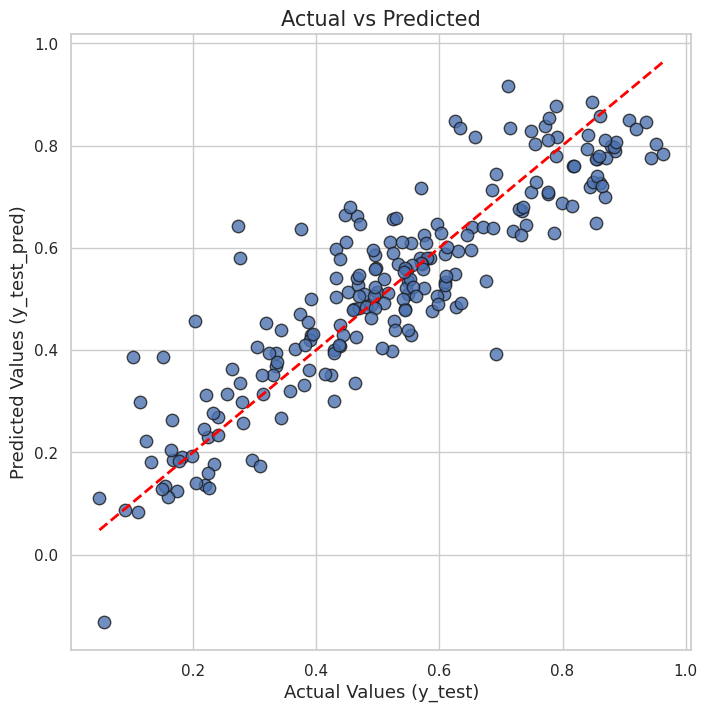

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot
ax.scatter(y_test, y_test_pred, alpha=0.8, edgecolors='k', s=80)

# Identity line (y=x)
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)

ax.set_title('Actual vs Predicted', fontsize=15)
ax.set_xlabel('Actual Values (y_test)', fontsize=13)
ax.set_ylabel('Predicted Values (y_test_pred)', fontsize=13)